# 0.0 Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import inflection 
import plotly.express as px
import umap.umap_ as umap

from matplotlib import pyplot as plt
from IPython.display import HTML
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn import metrics


## 0.1 Helper Functions

### Set Display

In [3]:
def notebook_settings():

    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns=None
    pd.options.display.max_rows=None
    pd.set_option( 'display.expand_frame_repr', False)

    sns.set()
notebook_settings()

In [4]:
# supress scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 0.2 Load Data

In [5]:
data = pd.read_csv('../data/raw/data.csv', encoding='unicode_escape')

# Planification (IoT)

# 1.0 Data Description

### 1.1 Data Dimensions

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.390,17850.000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.750,17850.000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.390,17850.000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.390,17850.000,United Kingdom


### 1.2 Rename Columns

In [8]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore( x ) # change to snakecase
cols_new = list( map( snakecase, cols_old ))

data.columns = cols_new # define the new columns

### 1.3 Check and fillout Nan

In [9]:
# check Na
data.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [10]:
# drop Na
data = data.dropna()

### 1.4 Change dtypes

In [11]:
# invoice data to datetime
data['invoice_date'] = pd.to_datetime(data['invoice_date'])

### 1.5 Descriptive Statistics

#### Numerical

In [12]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
quantity,406829.000,12.061,-80995.000,2.000,5.000,12.000,80995.000,248.693
invoice_date,406829,2011-07-10 16:30:57.879207424,2010-12-01 08:26:00,2011-04-06 15:02:00,2011-07-31 11:48:00,2011-10-20 13:06:00,2011-12-09 12:50:00,NaN
unit_price,406829.000,3.460,0.000,1.250,1.950,3.750,38970.000,69.315
customer_id,406829.000,15287.691,12346.000,13953.000,15152.000,16791.000,18287.000,1713.600


#### Categorical

In [13]:
data.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

# 2.0 Feature Engineering

In [14]:
df1 = data.copy()

In [15]:
# filter only customer_id column
df_ref = df1['customer_id'].drop_duplicates( ignore_index=True)

# revenue
df1['revenue'] = df1['unit_price'] * df1['quantity']

# Monetary
ref = df1[['customer_id', 'revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, ref, on='customer_id', how='left')

# recency
recency = df1[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
recency['recency_days'] = (df1['invoice_date'].max() -  recency['invoice_date']).dt.days
recency = recency[['customer_id', 'recency_days']]
df_ref = pd.merge(df_ref, recency, on='customer_id', how='left')

# frequency
frequency = df1[['invoice_no', 'customer_id']].drop_duplicates().groupby('customer_id').count().reset_index()
frequency.columns = ['customer_id', 'frequency']
df_ref = pd.merge(df_ref, frequency, on='customer_id', how='left')

# Avg Ticket
avg_ticket = df1[['customer_id', 'revenue']].groupby('customer_id').mean().reset_index().rename(columns={'revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, avg_ticket, on='customer_id', how='left')

# 3.0 Data Filtering

# 4.0 EDA

## 4.1 Hypothesis Map

## 4.2 Univariate Analysis

# 5.0 Data Preparation

### Standardization, Rescaling and Encoding

# 6.0 Feature Selection

## 6.1 Split Train & Validation

## 6.2 Fature Selection

### Boruta

### Fature Importance

# 7.0 Hyperparameter Fine-Tunning

In [16]:
df2 = df_ref.copy()

In [17]:
X = df2.drop( columns=['customer_id'] )

In [18]:
cluster = [2, 3, 4, 5, 6, 7, 8, 9, 10]

### Within-Cluster Sum of Squares (WSS)

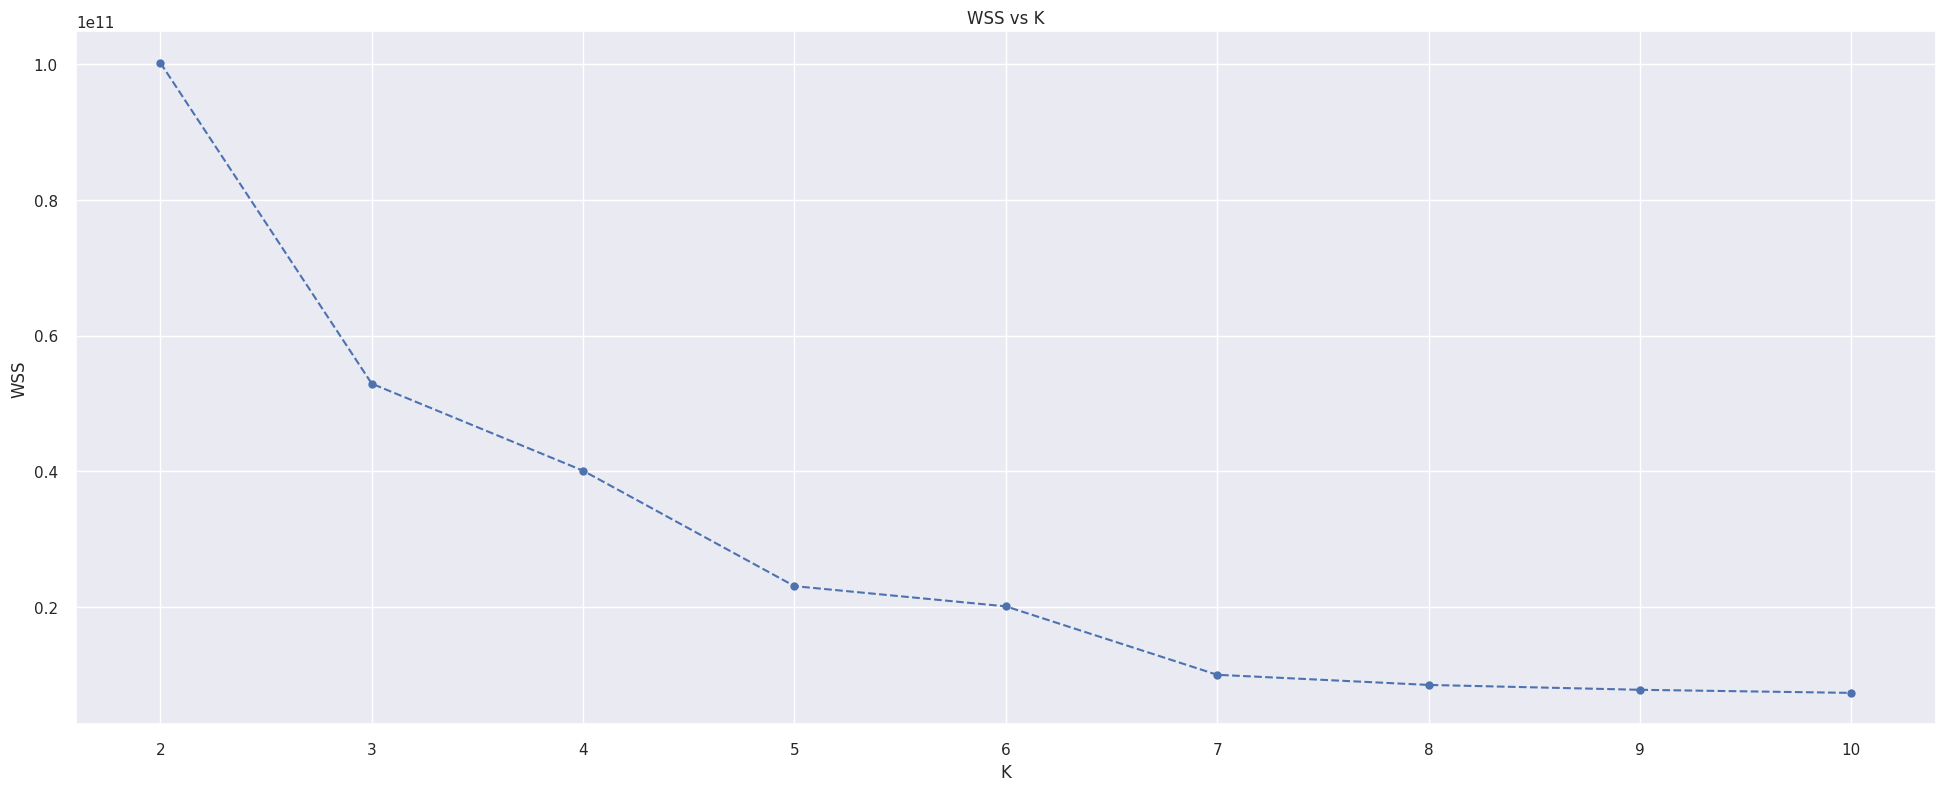

In [19]:
wss = []
for k in cluster:
    # model definition
    kmeans = KMeans(init='random', n_clusters=k, n_init=10,  max_iter=300, random_state=42)

    # model training
    kmeans.fit( X )

    #validation
    wss.append(kmeans.inertia_)

# plot wss - Elbow Method
plt.plot(cluster, wss, linestyle='--', marker='o');
plt.xlabel( 'K' );
plt.ylabel( 'WSS' );
plt.title('WSS vs K');

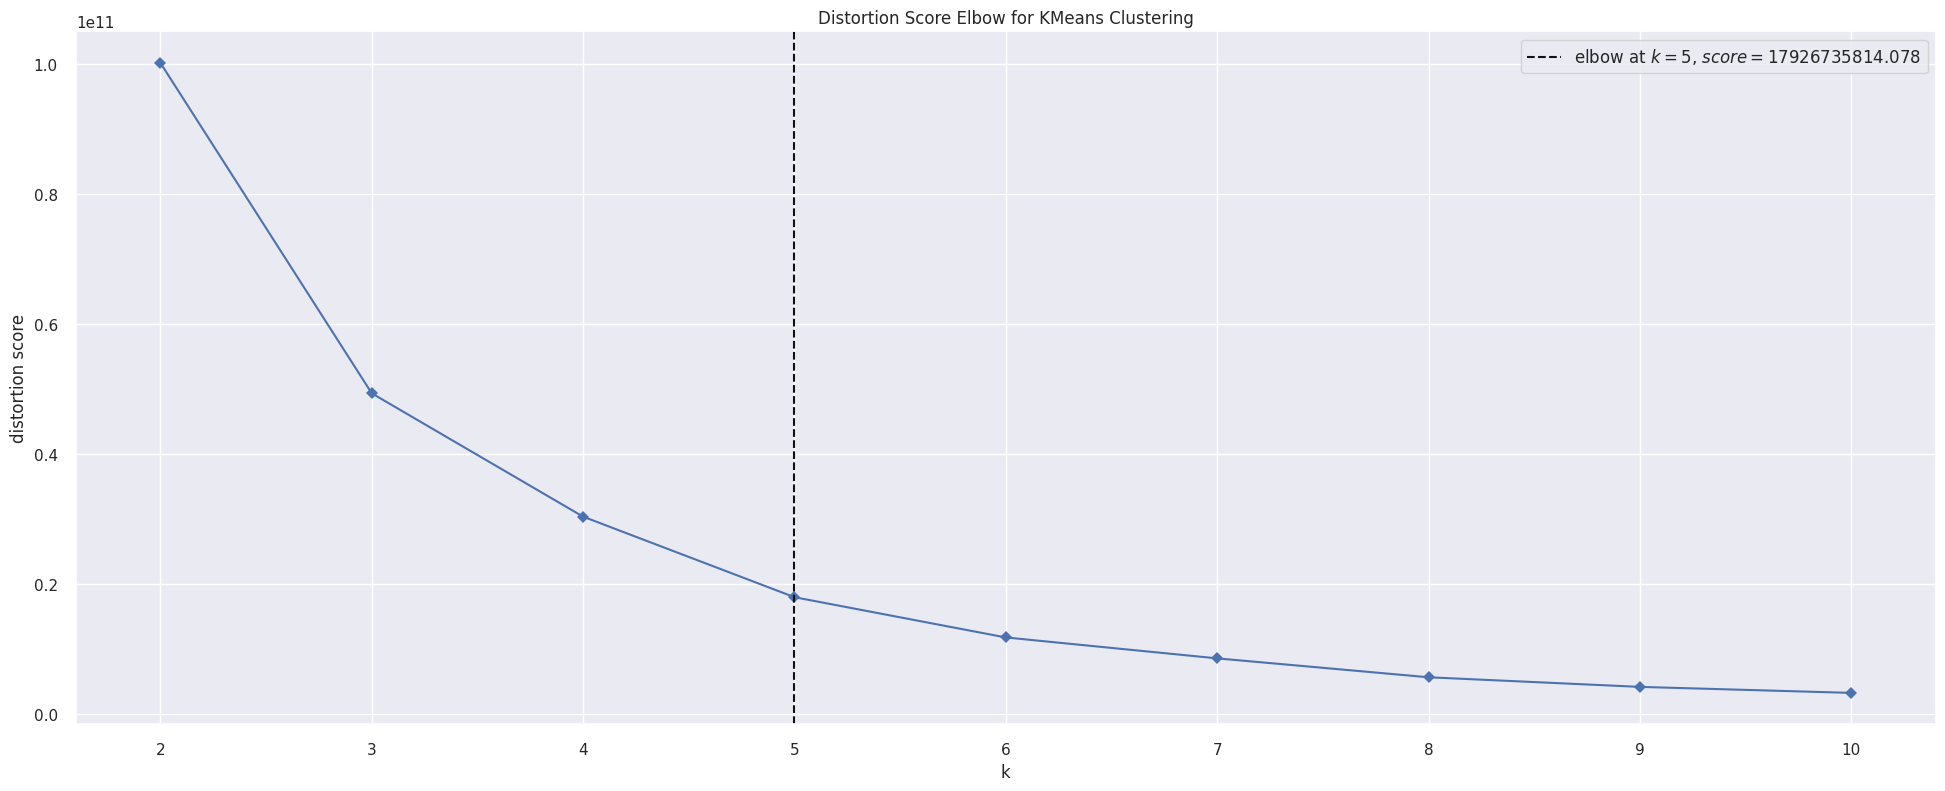

In [20]:
kmeans = KElbowVisualizer( KMeans(n_init=10), k=cluster, timings=False)
kmeans.fit( X );
kmeans.show();

### Silhouette Score

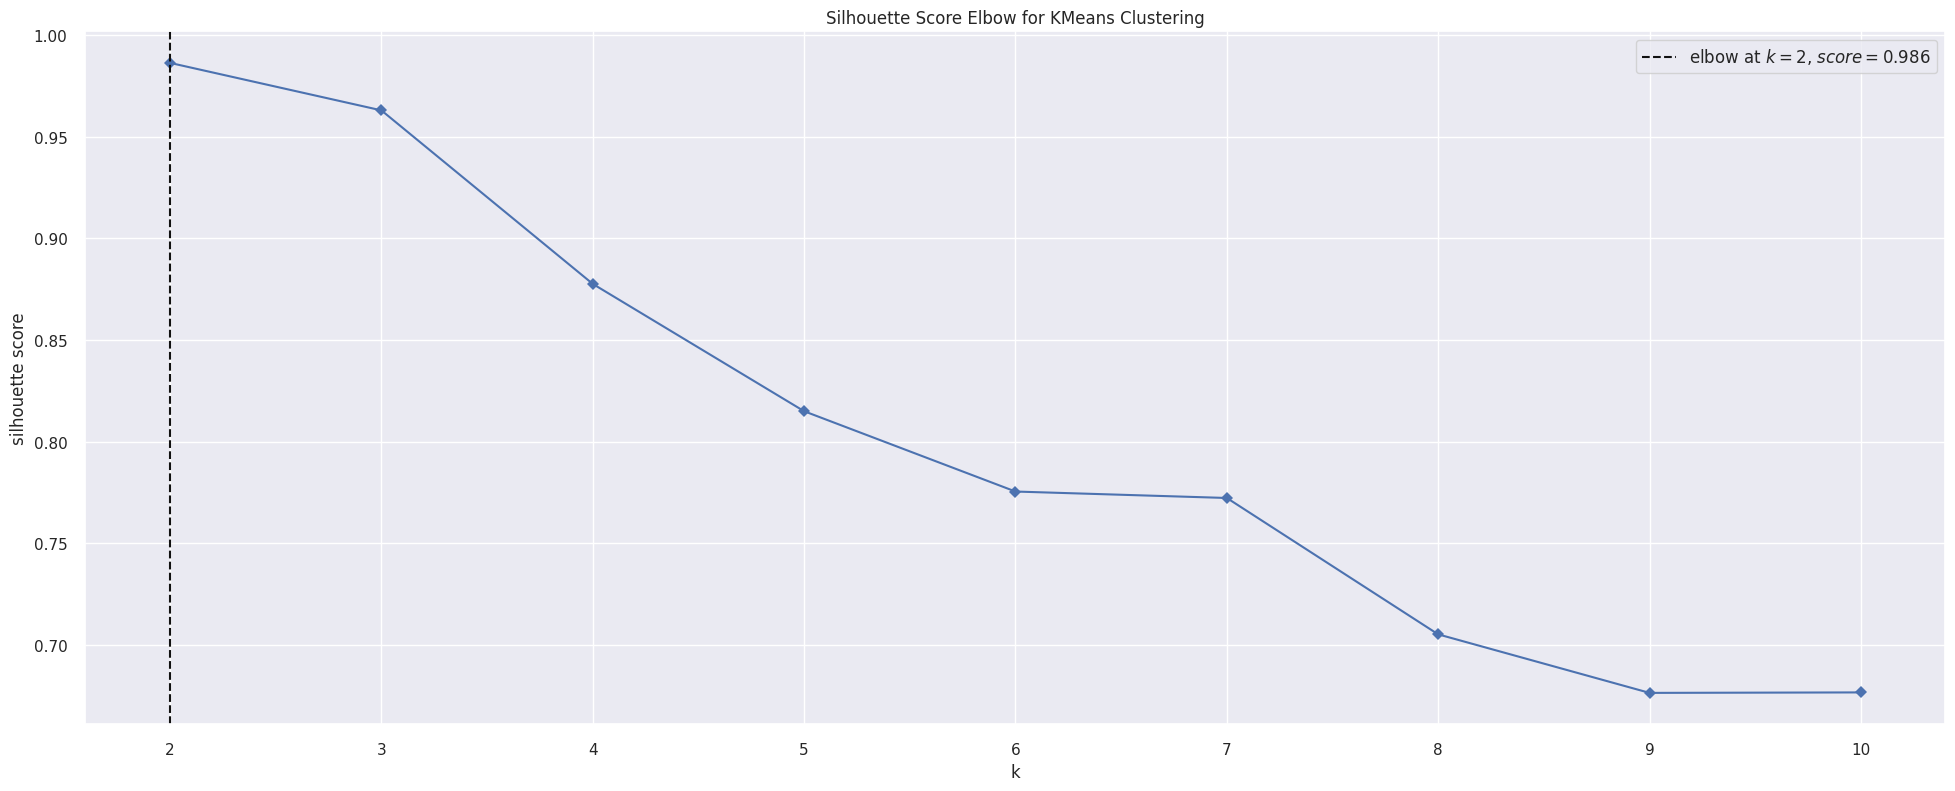

In [21]:
kmenas = KElbowVisualizer( KMeans(n_init=10), k=cluster, metric='silhouette', timings=False);
kmenas.fit( X );
kmenas.show();

### Silhouette Analysis

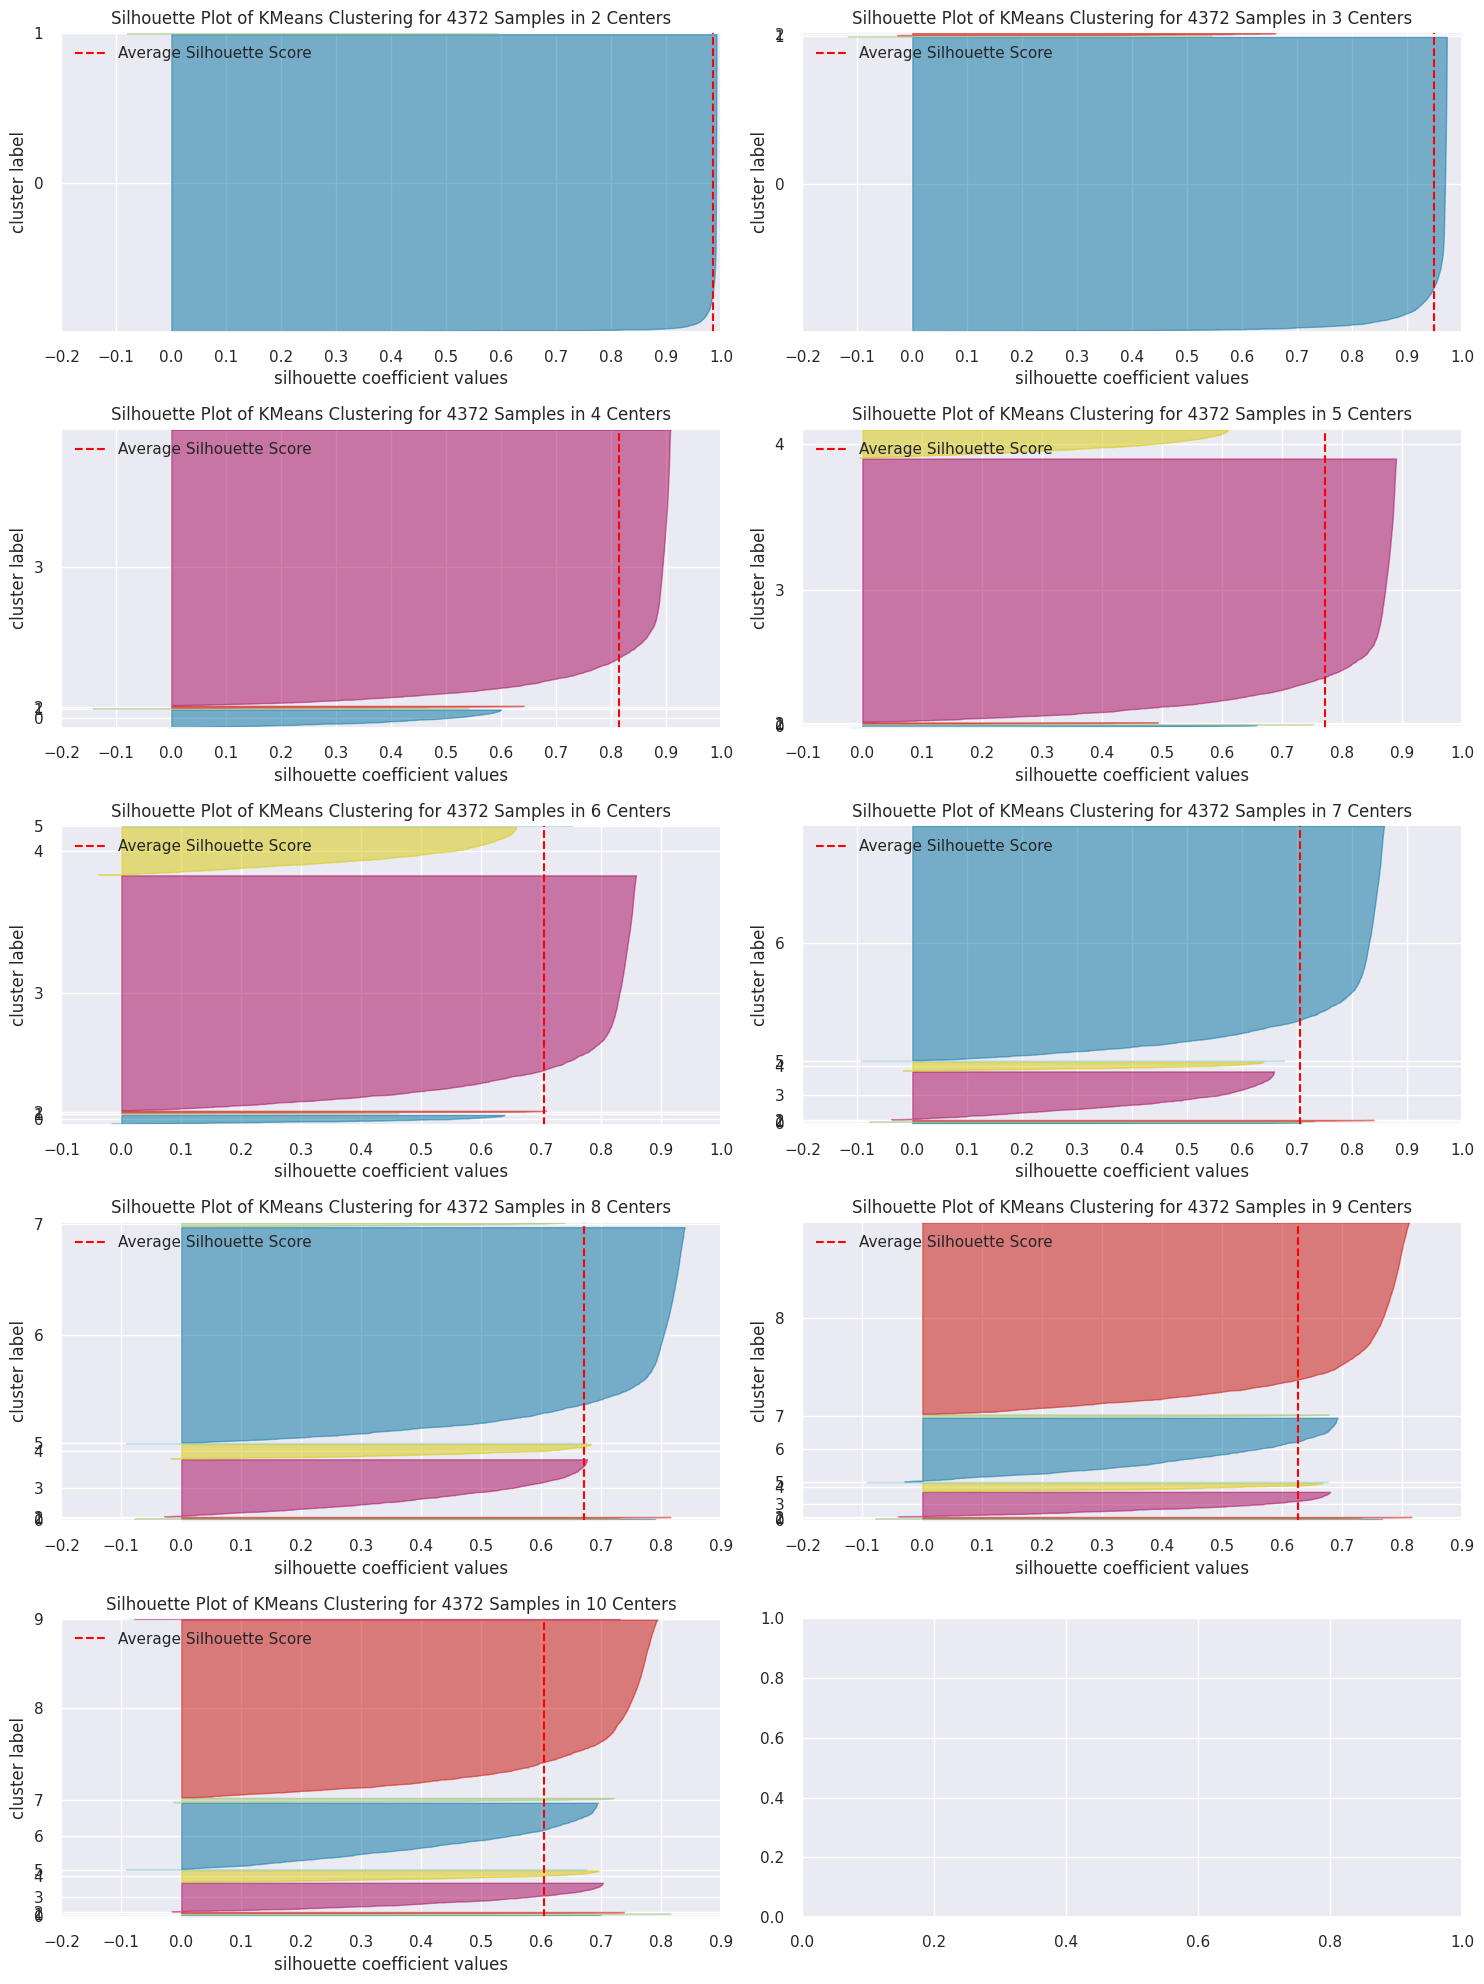

In [22]:
fig, ax = plt.subplots(5, 2, figsize=(15,20))

for k in cluster:
    km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod( k - 2, 2)

    viz = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q][mod])
    viz.fit( X )
    viz.finalize()

plt.tight_layout()
plt.show()

# 8.0 Machine Learnign Modeling

In [23]:
# model definition
k = 4
kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model trainig 
kmeans.fit ( X )

# clustering
labels = kmeans.labels_

### Cluster Validation

In [24]:
# WSS 
print( f'WSS value: {kmeans.inertia_}')

# Silhouette
print(f'SS Value: {metrics.silhouette_score( X, labels, metric="euclidean")}')

WSS value: 40056504196.36334


SS Value: 0.8139969114940825


# 9.0 Cluster Analysis

In [25]:
df3 = df_ref.copy()
df3['cluster'] = labels

In [26]:
df3.head()

,customer_id,revenue,recency_days,frequency,avg_ticket,cluster
0,17850.000,5288.630,301,35,16.951,0
1,13047.000,3079.100,31,18,15.710,3
2,12583.000,7187.340,2,18,28.635,0
3,13748.000,948.250,95,5,33.866,3
4,15100.000,635.100,329,6,105.850,3


### Visualization Inspection

In [27]:
# 3 clusters and without avg ticket
fig = px.scatter_3d(df3, x='recency_days', y='frequency', z='revenue', color='cluster')
fig.show()

/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



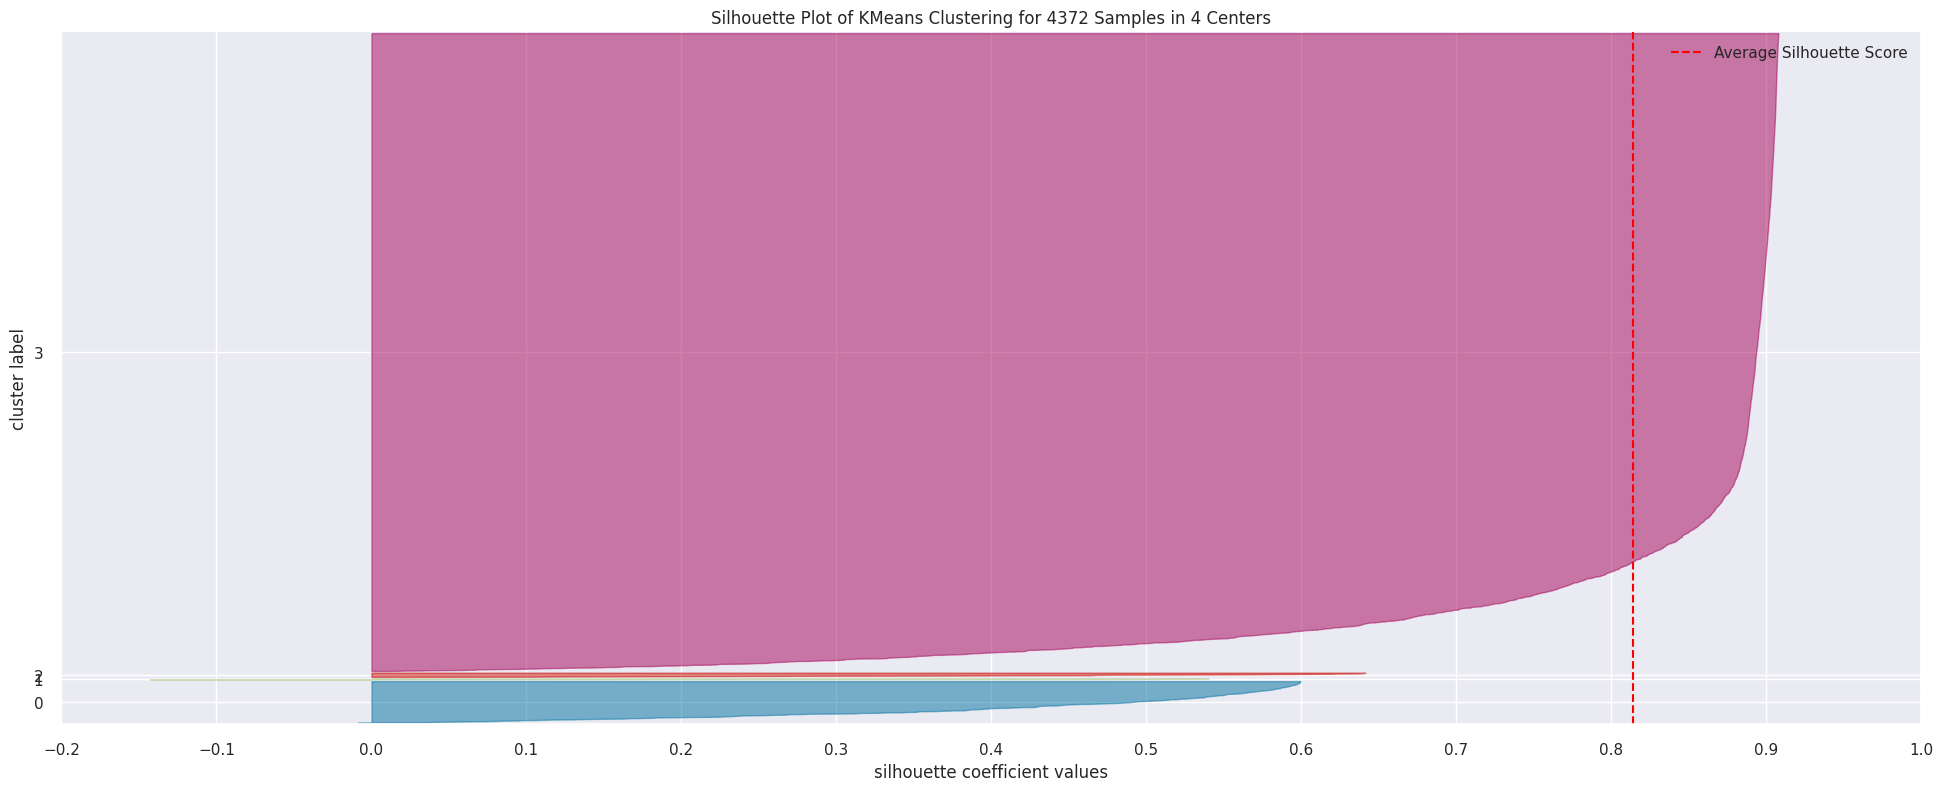

In [28]:
# 4 Clusters with avg ticket
viz = SilhouetteVisualizer( kmeans, colors='yellowbrick')
viz.fit( X )
viz.finalize()

### 2D plot

In [29]:
df3.head()

,customer_id,revenue,recency_days,frequency,avg_ticket,cluster
0,17850.000,5288.630,301,35,16.951,0
1,13047.000,3079.100,31,18,15.710,3
2,12583.000,7187.340,2,18,28.635,0
3,13748.000,948.250,95,5,33.866,3
4,15100.000,635.100,329,6,105.850,3


/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-p

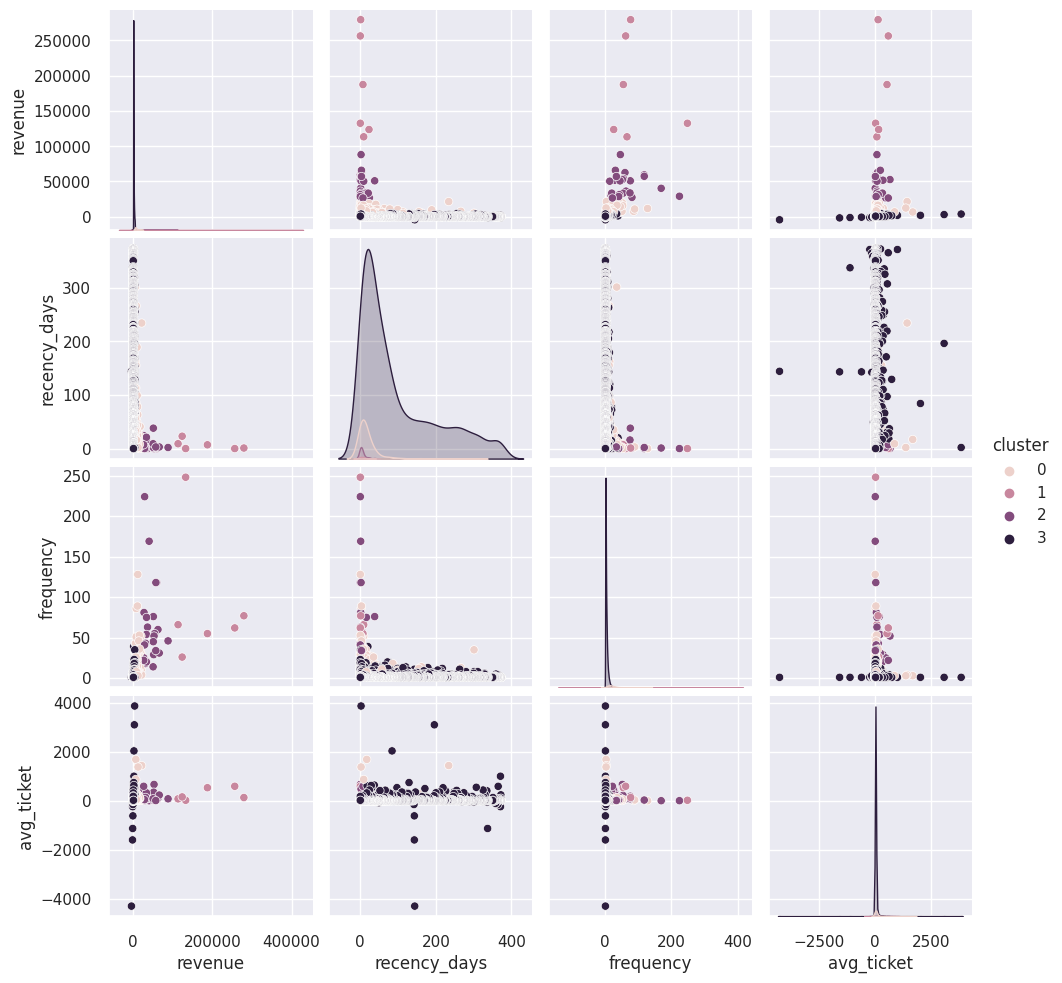

In [30]:
df_viz = df3.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

### UMAP - t-SNE (Manifold)

/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarnin

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

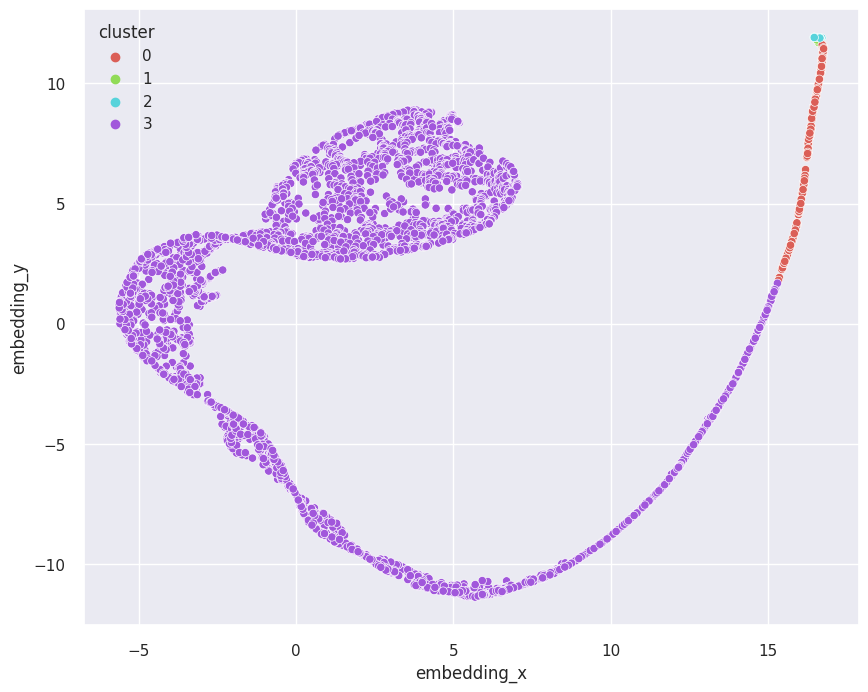

In [48]:
reducer = umap.UMAP( n_neighbors=80, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
plt.figure(figsize=(10,8))
sns.scatterplot(x='embedding_x', y='embedding_y', 
                data=df_viz, 
                hue='cluster', 
                palette=sns.color_palette( 'hls', n_colors=len(df_viz['cluster'].unique())))

### Cluster Profile

In [46]:
# Number of customers
df_cluster = df3[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['per_customer'] = 100 * df_cluster['customer_id'] / df_cluster['customer_id'].sum()

# Avg revenue
df_avg_revenue = df3[['revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_revenue, on='cluster', how='inner')

# Avg recency
df_avg_recency = df3[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, on='cluster', how='inner')

# Avg frequency
df_avg_frequency = df3[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, on='cluster', how='inner')

# Avg Ticket
df_avg_ticket = df3[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, on='cluster', how='inner')

In [47]:
df_cluster

,cluster,customer_id,per_customer,revenue,recency_days,frequency,avg_ticket
0,0,267,6.107,8089.029,19.824,19.528,62.783
1,1,6,0.137,182181.982,6.667,89.000,253.626
2,2,28,0.640,42614.387,5.679,57.821,162.863
3,3,4071,93.115,946.696,96.430,3.641,25.360


# 10.0 Deploy